In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from pylab import rcParams

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

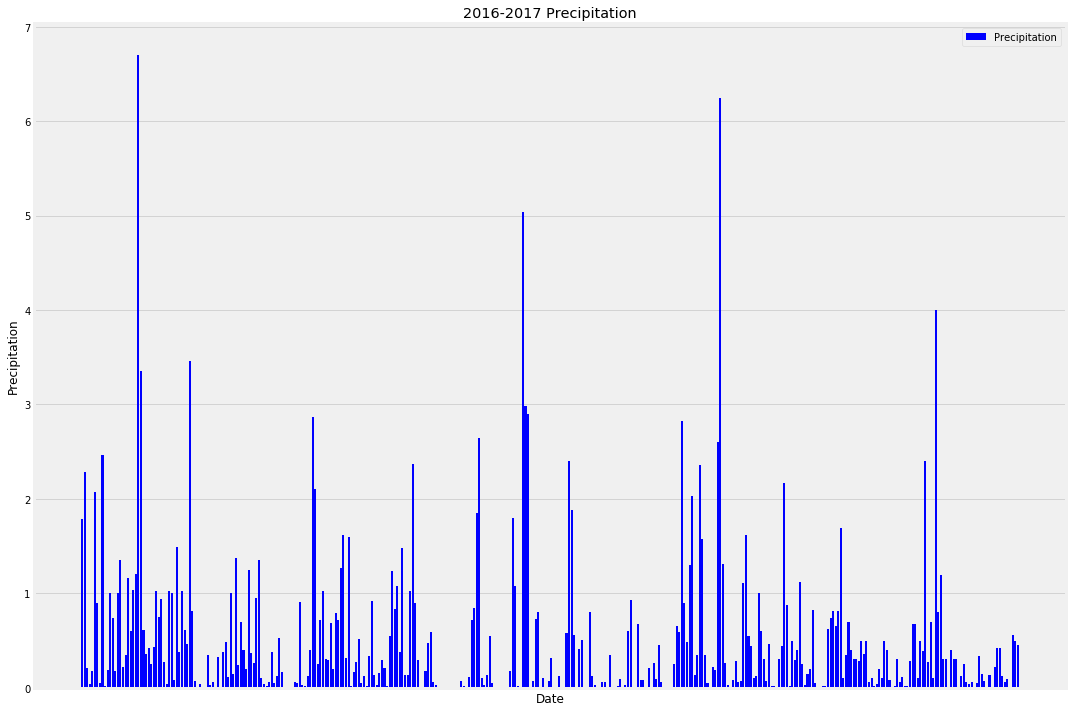

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
conn = engine.connect()
climate = pd.read_sql('SELECT Date FROM Measurement ORDER BY ID DESC LIMIT 1', conn)
climate
# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').statement

# Save the query results as a Pandas DataFrame and set the index to the date column
meas_2016 = pd.read_sql_query(last_year, session.bind.engine)
meas_2016 = meas_2016.set_index('date')

# Sort the dataframe by date
prec_2016 = meas_2016.sort_index(ascending = 1)

# Use Pandas Plotting with Matplotlib to plot the data

rcParams['figure.figsize'] = 15, 10
plt.bar(prec_2016.index, prec_2016['prcp'], color='blue', label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('2016-2017 Precipitation')
plt.grid(color='lightgrey', which = 'major')
plt.legend()
plt.xticks([])
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_2016.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = pd.read_sql('SELECT DISTINCT station FROM Station', conn)
stations.count()

station    9
dtype: int64

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_group = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs))).all()

for row in station_group:
    print(row)
    
print(f' The most active station is {station_group[0]}')

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
 The most active station is ('USC00519281', 2772)


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_data = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter_by(station = 'USC00519281').all()

for row in station_data:
    print(row)



('USC00519281', 54.0, 85.0, 71.66378066378067)


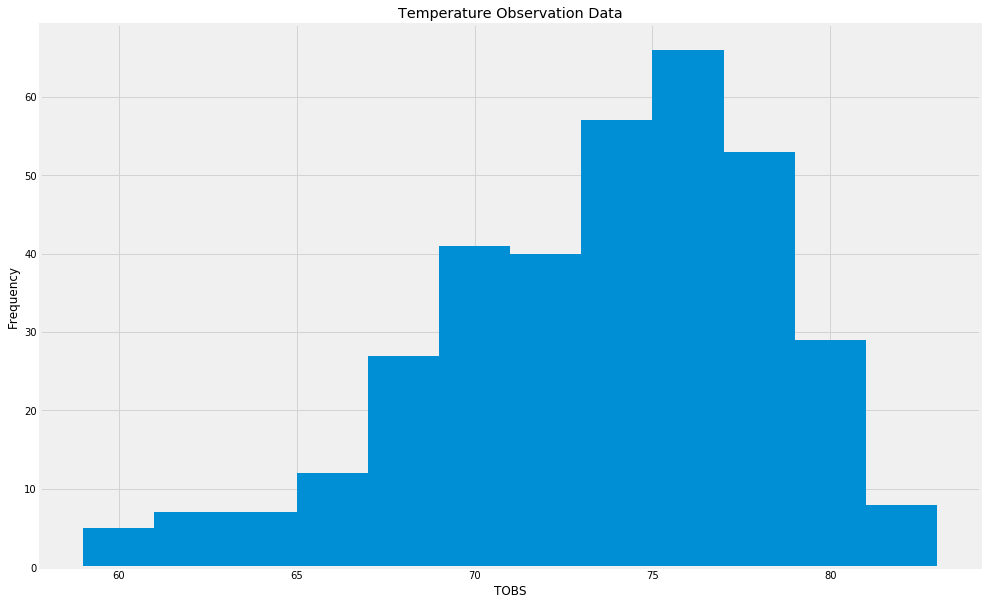

In [17]:
##### Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_year_temp = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter_by(station = 'USC00519281').filter(Measurement.date > '2016-08-22').statement
temp_df = pd.read_sql_query(last_year_temp, session.bind.engine)
df = temp_df[['tobs']]
df.head()

# plot
rcParams['figure.figsize'] = 15, 10
plt.hist(df.tobs, bins=12)
plt.grid(color='lightgrey')
plt.xlabel("TOBS")
plt.ylabel("Frequency")
plt.title('Temperature Observation Data')
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-22', '2017-08-24'))
x = calc_temps('2016-08-22', '2016-08-31')


[(58.0, 74.59901654000895, 87.0)]


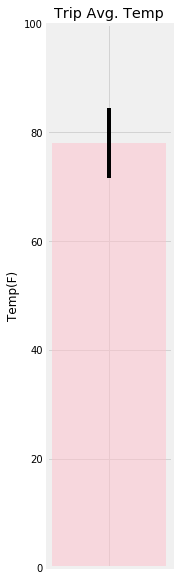

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
rcParams['figure.figsize'] = 2, 10
yerr = (float(x[0][2]) - float(x[0][0]))/2
plt.bar(" ", x[0][1], width = 0.5, yerr=(yerr), color='pink', alpha=0.5)
plt.ylabel('Temp(F)')
plt.grid(color='lightgrey')
plt.ylim(0,100)
plt.title('Trip Avg. Temp')
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


sel = [Measurement.station, Measurement.prcp, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
same_station = session.query(*sel, func.sum(Measurement.prcp)).filter(Measurement.station == Station.station).\
    group_by(Measurement.station).order_by(desc(func.sum(Measurement.prcp))).\
    filter(Measurement.date >= '2016-08-22').filter(Measurement.date <= '2016-08-31').all()

for row in same_station:
    for i in range(2,8):
        print(row[i])
    print(" ")
    

USC00516128
MANOA LYON ARBO 785.2, HI US
21.3331
-157.8025
152.4
8.94
 
USC00519281
WAIHEE 837.5, HI US
21.45167
-157.84888999999998
32.9
7.639999999999999
 
USC00513117
KANEOHE 838.1, HI US
21.4234
-157.8015
14.6
3.94
 
USC00514830
KUALOA RANCH HEADQUARTERS 886.9, HI US
21.5213
-157.8374
7.0
2.55
 
USC00519523
WAIMANALO EXPERIMENTAL FARM, HI US
21.33556
-157.71139
19.5
2.24
 
USC00519397
WAIKIKI 717.2, HI US
21.2716
-157.8168
3.0
0.7000000000000001
 
USC00517948
PEARL CITY, HI US
21.3934
-157.9751
11.9
0.06
 


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
date_start = dt.date(2016,8,22)
date_end = dt.date(2016,8,31)

# Use the start and end date to create a range of dates
trip_dates = []
days_vaca = 10

for r in range (0, days_vaca):
    d = []
    a= (date_start + dt.timedelta(days = r))
    d.append(a)
    # Stip off the year and save a list of %m-%d strings
    b=(a.strftime("%m-%d"))
    d.append(b)
    # Loop through the list of %m-%d strings and calculate the normals for each date
    c=(daily_normals(b))
    for tmin, tavg, tmax in c:
        d.append(tmin)
        d.append(tavg)
        d.append(tmax)
    normals.append(d)


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['Date', 'Days', 'tmin', 'tavg', 'tmax']).set_index('Date')
df['base'] = 0
df.head()

,Days,tmin,tavg,tmax,base
Date,,,,,
2016-08-22,08-22,69.0,76.471698,84.0,0
2016-08-23,08-23,67.0,76.692308,87.0,0
2016-08-24,08-24,70.0,75.961538,84.0,0
2016-08-25,08-25,69.0,76.960784,82.0,0
2016-08-26,08-26,71.0,76.568627,84.0,0


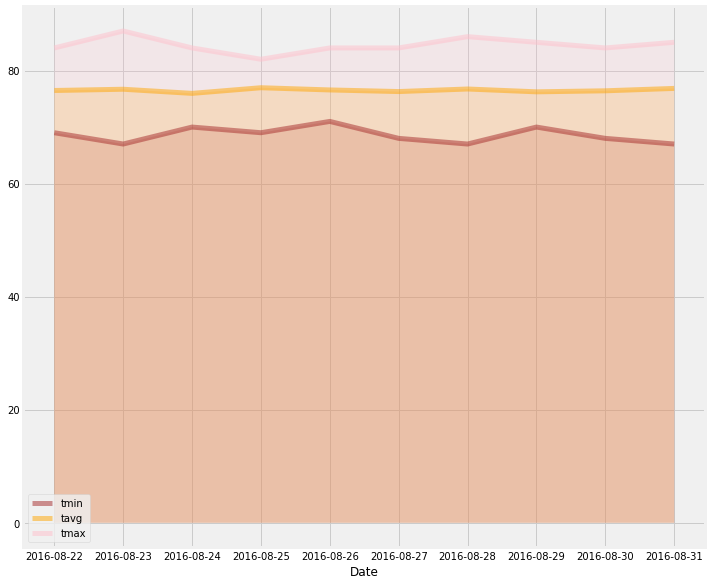

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
x = df.index
y1 = df['tmin']
y2 = df['tavg']
y3 = df['tmax']
y4 = df['base']


fig, ax = plt.subplots(1, figsize=(10,8))

ax.plot_date(x, y1, lw=2, label = 'tmin', color='brown', alpha=0.5, fmt="r-", linewidth=5)
ax.plot_date(x, y2, lw=2, label = 'tavg', color='orange', alpha=0.5, fmt="r-", linewidth=5)
ax.plot_date(x, y3, lw=2, label = 'tmax', color='pink', alpha=0.5, fmt="r-", linewidth=5)
ax.fill_between(x, y1, y4, facecolor='brown', alpha=0.2)
ax.fill_between(x, y2, y4, facecolor='orange',alpha=0.2)
ax.fill_between(x, y3, y4, facecolor='pink',alpha=0.2)


plt.legend(loc='best')
plt.tight_layout()
plt.ylim = ((0,90))
plt.xlabel('Date')
plt.show()